# 🎁 Wrapper for `wgrib2`

Herbie provides a very basic wrapper for wgrib2. Note that the **wgrbi2** functionality requires **wgrib2** is in your path (it can be installed via conda on Linux), and it can only perform actions on _local_ grib2 files.

> Note: I attempted to open-source and re-publish the wgrib2 docs here: https://wgrib2-docs.readthedocs.io/en/latest/  
> (these are _unofficial_ wgrib2 docs).

In [1]:
from herbie import Herbie, wgrib2
from pathlib import Path
import pandas as pd

import xarray as xr
from toolbox import EasyMap, ccrs, pc

Lets start by getting a GRIB2 file...

In [2]:
H = Herbie("2023-02-01")

ss = "[U|V]GRD:10 m above ground"  # ss is for search
H.download(ss)

myFile = H.get_localFilePath(ss)
myFile, myFile.exists()

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2023-Feb-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


(PosixPath('/home/blaylock/data/hrrr/20230201/subset_d7ef391b__hrrr.t00z.wrfsfcf00.grib2'),
 True)

You can print the raw GRIB2 inventory from wgrib2 like this:

In [3]:
# Print the standard inventory of a grib2 file
print(wgrib2.inventory(myFile))

1:0:d=2023020100:UGRD:10 m above ground:anl:
2:2381615:d=2023020100:VGRD:10 m above ground:anl:



You can create and save the `<filename>.grib2.idx` inventory text files like this:

In [4]:
# Create a standard inventory file

idxFile = wgrib2.create_inventory_file(myFile)

idxFile, idxFile.exists()

(PosixPath('/home/blaylock/data/hrrr/20230201/subset_d7ef391b__hrrr.t00z.wrfsfcf00.grib2.idx'),
 True)

In [5]:
# Read the index file (with pandas)
pd.read_csv(idxFile, delimiter=":", header=None)

,0,1,2,3,4,5,6
0,1,0,d=2023020100,UGRD,10 m above ground,anl,NaN
1,2,2381615,d=2023020100,VGRD,10 m above ground,anl,NaN


You can check if the vector quantities are grid-relative or earth-relative vectors

In [6]:
wgrib2.vector_relative(myFile)

All winds are grid-relative winds.


{'winds(grid)'}

You can create a regional subset of the file. This uses the `-small_grib` option to trim the GRIB2 file to a bounding box. This method will, by default, also make a cooresponding `.idx` file.

In [7]:
# Create a regional subset of the file

extent = (-100, -90, 30, 40)

subset_file = wgrib2.region(myFile, extent, name="myRegion")
subset_file

PosixPath('/home/blaylock/data/hrrr/20230201/myRegion_subset_d7ef391b__hrrr.t00z.wrfsfcf00.grib2')

In [8]:
# Look at the inventory file again to see it is different from before the region subset
pd.read_csv(str(subset_file) + ".idx", delimiter=":", header=None)

,0,1,2,3,4,5,6
0,1,0,d=2023020100,UGRD,10 m above ground,anl,NaN
1,2,78653,d=2023020100,VGRD,10 m above ground,anl,NaN


Let's look at that data, just to make sure it handeled the subset

In [9]:
myFile, subset_file

(PosixPath('/home/blaylock/data/hrrr/20230201/subset_d7ef391b__hrrr.t00z.wrfsfcf00.grib2'),
 PosixPath('/home/blaylock/data/hrrr/20230201/myRegion_subset_d7ef391b__hrrr.t00z.wrfsfcf00.grib2'))

In [10]:
# Get crs from a regular Herbie object
ds = H.xarray(ss)
crs = ds.herbie.crs

# (can't use Herbie to open FILE yet, so just use xarray)
ds_region = xr.open_dataset(subset_file, engine="cfgrib")

/home/blaylock/GITHUB/Herbie/herbie/core.py:1052: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


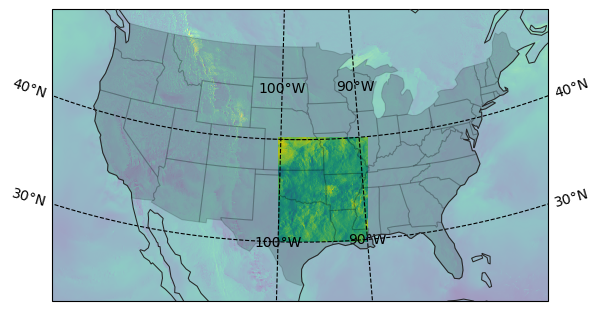

In [11]:
ax = EasyMap(crs=crs).STATES(color="k").ax
ax.pcolormesh(ds.longitude, ds.latitude, ds.u10, alpha=0.5, transform=pc)
ax.pcolormesh(ds_region.longitude, ds_region.latitude, ds_region.u10, transform=pc)

ax.gridlines(xlocs=extent[:2], ylocs=extent[2:], color="k", ls="--", draw_labels=True)

Well that is what we expected, so that is good.

In [12]:
ds

<xarray.Dataset>
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 2023-02-01
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 10.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           datetime64[ns] 2023-02-01
Dimensions without coordinates: y, x
Data variables:
    u10                  (y, x) float32 -4.17 -4.17 -4.17 ... 5.205 5.205 5.205
    v10                  (y, x) float32 ...
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20230201/subset_d7ef391...
    search:            [U|V]GRD:10 m above ground

In [13]:
ds_region

<xarray.Dataset>
Dimensions:            (y: 381, x: 324)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 29.97 29.97 29.98 ... 39.92 39.92 39.92
    longitude          (y, x) float64 260.0 260.1 260.1 ... 271.0 271.0 271.1
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    u10                (y, x) float32 -0.92 -0.8575 -1.108 ... 2.267 2.267 2.33
    v10                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-03-11T14:45 GRIB to CDM+CF via cfgrib-0.9.1...